In [2]:
import cv2
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
import numpy as np
import matplotlib.pyplot as plt
from pylab import savefig
%matplotlib inline

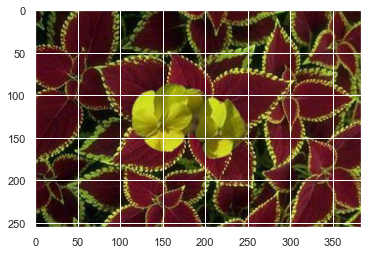

In [20]:
img = plt.imread("./1.jpg")
noisy = np.copy(img)
plt.imshow(img)

In [21]:
noisy[0:50, 0:50,:] = noisy[0:15, 0:50,:] + np.random.normal(0, 50, (50, 50, 3))
plt.imsave("./10.jpg", noisy, format='jpg')

ValueError: operands could not be broadcast together with shapes (15,50,3) (50,50,3) 

In [35]:
reconstruction = np.load("./1_reconstruction.npy")
features = np.load("./1_features.npy")

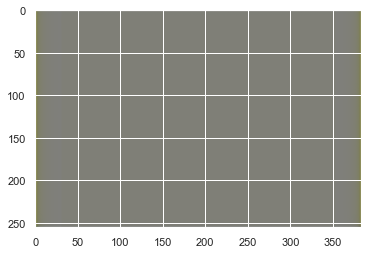

In [37]:
np

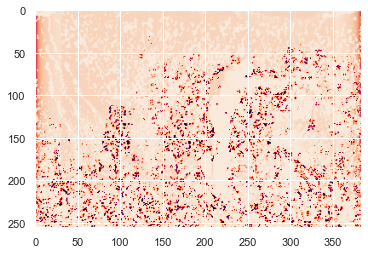

In [15]:
error = np.load("./6_mask.npy")
plt.imshow(error)

<AxesSubplot:>

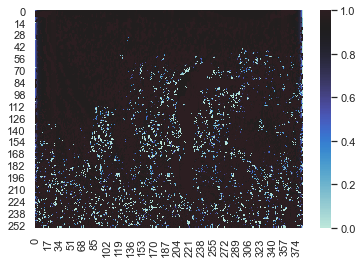

In [16]:
sns.heatmap(error, center=np.mean(error))